In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

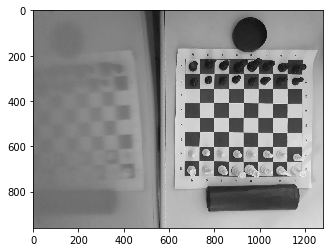

In [2]:
img = cv2.imread("Inicial/inicial0.jpg", 0)

plt.imshow(img, cmap = "gray")

In [3]:
aux = np.zeros((800, 800), dtype = np.float32)
pts_aux = np.float32([[0,0],[aux.shape[1], 0],[aux.shape[1],aux.shape[0]],[0,aux.shape[0]]])

In [4]:
points = []
ix,iy = -1,-1

def get_points(event,x,y,flags,param):
    global ix,iy,drawing,mode, points

    if event == cv2.EVENT_LBUTTONDOWN:
        ix,iy = x,y
        #print(x, y)
        points.append([x, y])

img_r = cv2.resize(img, (int(img.shape[1]/1.4), int(img.shape[0]/1.4)))

#descomentar abaixo para clicar na tela

# cv2.imshow("click", img_r)
# cv2.setMouseCallback('click', get_points)

# while (1):
#     k = cv2.waitKey(1) & 0xFF
#     if k == ord('q') or k == 27:
#         break
        
cv2.destroyAllWindows()


pts1 = np.float32(points[:4])

In [5]:
pts1

array([], dtype=float32)

In [6]:
pts1 = np.array([[481., 156.], [852., 158.], [852., 522.], [478., 523.]], dtype = np.float32)

In [7]:
M = cv2.getPerspectiveTransform(pts1, pts_aux)

In [8]:
perspectiva = cv2.warpPerspective(img_r, M,(aux.shape[1], aux.shape[0]), aux, borderMode = cv2.BORDER_TRANSPARENT)

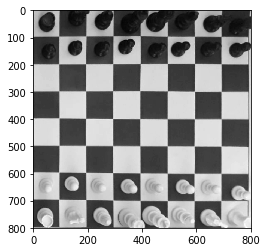

In [9]:
plt.imshow(perspectiva, cmap = "gray")

In [10]:
pts1

array([[481., 156.],
       [852., 158.],
       [852., 522.],
       [478., 523.]], dtype=float32)

In [11]:
lst = []
for i in range(8):
    for j in range(8):
        lst.append(perspectiva[perspectiva.shape[1]*i//8:perspectiva.shape[1]*(i+1)//8, perspectiva.shape[0]*j//8:perspectiva.shape[0]*(j+1)//8])

In [12]:
np.array(lst).shape

(64, 100, 100)

In [13]:
array = np.array(lst).reshape(8, 8, 100, -1)

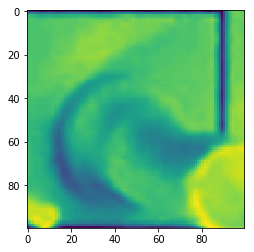

In [14]:
plt.imshow(array[7, 7])

In [15]:
import os
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk("Inicial/"):
    for file in f:
        if '.jpg' in file:
            files.append(os.path.join(r, file))

In [16]:
perspectiva = []
lst_geral = []

for path in sorted(files):
    img = cv2.imread(path, 0)
    M = cv2.getPerspectiveTransform(pts1, pts_aux)
    img_r = cv2.resize(img, (int(img.shape[1]/1.4), int(img.shape[0]/1.4)))
    perspectiva.append(cv2.warpPerspective(img_r, M,(aux.shape[1], aux.shape[0]), aux, borderMode = cv2.BORDER_TRANSPARENT))
    lst = []
    for i in range(8):
        for j in range(8):
            lst.append(perspectiva[-1][perspectiva[-1].shape[1]*i//8:perspectiva[-1].shape[1]*(i+1)//8, perspectiva[-1].shape[0]*j//8:perspectiva[-1].shape[0]*(j+1)//8])
    array = np.array(lst).reshape(8, 8, 100, -1)
    lst_geral.append(array)

In [17]:
array_imgs = np.array(perspectiva)
array_geral = np.array(lst_geral)

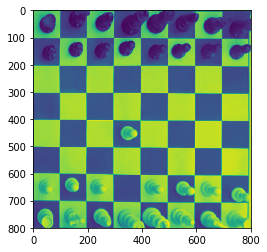

In [18]:
plt.imshow(perspectiva[1])

In [19]:
array_geral.shape

(6, 8, 8, 100, 100)

In [20]:
def center_image(img, p = 0.35, boolean = True):
    if boolean == False:
        return img
    w, h = img.shape
    cw, ch = w//2, h//2
    #p = 0.4 #max 0.5
    return img[int(cw - w*p): int(cw + w*p), int(ch - h*p) : int(ch + h*p)]

(70, 70)


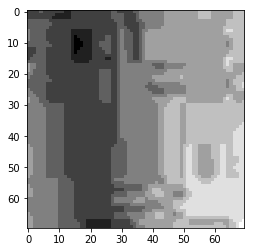

In [21]:
_ = center_image(array_geral[1][3, 3], p = 0.35)
print(_.shape)
# print(_)
plt.imshow(_, cmap = "gray")

In [22]:
def check_diff(a, b):
    M = max(a, b)
    return abs(a-b)/M

def dist_imgs(a, b, bins = 256):
    hista = cv2.calcHist([a],[0],None,[bins],[0,256]).ravel()
    histb = cv2.calcHist([b],[0],None,[bins],[0,256]).ravel()
    
    hista_n = hista/np.linalg.norm(hista)
    histb_n = histb/np.linalg.norm(histb)
    
    return 1 - check_diff(np.std(hista), np.std(histb))
    
    return np.max(np.correlate(hista_n, histb_n, "full"))

In [23]:
dist_imgs(array_geral[0][3, 3], array_geral[1][3, 3])

0.5823542177677155

In [24]:
dist_imgs(array_geral[3][2, 5], array_geral[4][2, 5])

0.3607257604598999

In [25]:
def movement(array_geral, jogada = 1, use_center = False, p = 0.35):
    imgs = (jogada-1, jogada)
    lst, two_low = [], []
    
#     prev = center_image(array_geral[imgs[0]], p = p, boolean = use_center)
#     curr = center_image(array_geral[imgs[1]], p = p, boolean = use_center)
    
    for i in range(8):
        for j in range(8):
            prev = center_image(array_geral[imgs[0]][i, j], p = p, boolean = use_center)
            curr = center_image(array_geral[imgs[1]][i, j], p = p, boolean = use_center)
            dist_imgs(prev, curr)
            lst.append(dist_imgs(prev, curr))
    lst = np.array(lst).reshape(8, 8)
    
    for i in range(2):
        idx = np.argmin(lst, axis = None) 
        ind = np.unravel_index(idx, lst.shape)

        two_low.append(ind)
    
        lst[ind[0], ind[1]] = 1
    return np.array(two_low)

In [26]:
%%time

for i in range(1, 6):
    print("Jogada {}: \n {}".format(i, movement(array_geral, jogada = i, use_center = False, p = 0.35)))

Jogada 1: 
 [[4 3]
 [6 3]]
Jogada 2: 
 [[3 5]
 [1 5]]
Jogada 3: 
 [[4 2]
 [6 2]]
Jogada 4: 
 [[2 5]
 [0 6]]
Jogada 5: 
 [[7 6]
 [5 5]]
CPU times: user 120 ms, sys: 0 ns, total: 120 ms
Wall time: 119 ms


Correto:

Jogada 1:
##### 4 3
##### 6 3
Jogada 2:
##### 1 5
##### 3 5
Jogada 3:
##### 6 2
##### 4 2
Jogada 4:
##### 0 6
##### 2 5
Jogada 5:
##### 7 6
##### 5 5

In [27]:
%%time
for i in range(1, 6):
    print("Jogada {}: \n {}".format(i, movement(array_geral, jogada = i, use_center = True, p = 0.45)))

Jogada 1: 
 [[4 3]
 [6 3]]
Jogada 2: 
 [[3 5]
 [1 5]]
Jogada 3: 
 [[4 2]
 [6 2]]
Jogada 4: 
 [[2 5]
 [0 6]]
Jogada 5: 
 [[5 5]
 [7 6]]
CPU times: user 97.1 ms, sys: 2.28 ms, total: 99.3 ms
Wall time: 98.6 ms


In [28]:
def debug_step(n, pos, center = False, p = 0.35, bins = 32):
    fig, axs = plt.subplots(1, 3, figsize = (20, 6))
    
    img1 = array_geral[n][pos[0], pos[1]]
    img2 = array_geral[n+1][pos[0], pos[1]]
    
    if center == True:
        img1 = center_image(img1, p = p)
        img2 = center_image(img2, p = p)
    
    h1 = cv2.calcHist([img1],[0],None,[bins],[0,256]).ravel()
    h2 = cv2.calcHist([img2],[0],None,[bins],[0,256]).ravel()
    
    
    axs[0].imshow(img1)
    axs[1].imshow(img2)
    
    axs[2].plot(h1)
    axs[2].plot(h2)
    
    return(img1, img2, h1, h2, dist_imgs(img1, img2))
    
    #return dist_imgs(array_geral[n][pos[0], pos[1]], array_geral[n+1][pos[0], pos[1]])

0.6810510158538818

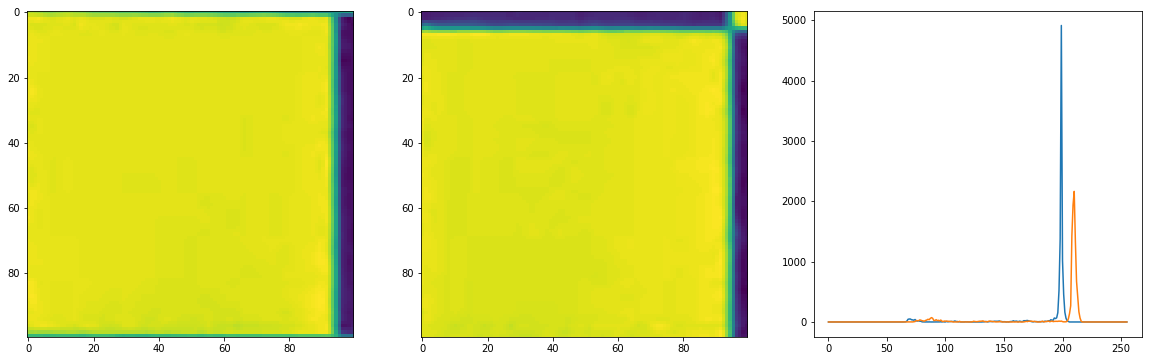

In [29]:
debug_step(0, (4, 4), center = False, p = 0.5, bins = 256)[-1]

In [30]:
###

In [31]:
%%time

jogadas = []
for i in range(1, 6):
    jogadas.append(movement(array_geral, jogada = i, use_center = False, p = 0.45))
    
jogadas = np.array(jogadas)

CPU times: user 90.3 ms, sys: 878 µs, total: 91.2 ms
Wall time: 90.7 ms


In [32]:
jogadas

array([[[4, 3],
        [6, 3]],

       [[3, 5],
        [1, 5]],

       [[4, 2],
        [6, 2]],

       [[2, 5],
        [0, 6]],

       [[7, 6],
        [5, 5]]])

In [33]:
def matrix_to_chess_notation(array):
    pos1, pos2 = array
    l1, n1 = chr(97 + pos1[1]), 8 - pos1[0]
    l2, n2 = chr(97 + pos2[1]), 8 - pos2[0]
    return ("{}{}{}{}".format(l1, n1, l2, n2), "{}{}{}{}".format(l2, n2, l1, n1))

In [34]:
array_jogadas = np.array([matrix_to_chess_notation(x) for x in jogadas])

In [35]:
array_jogadas

array([['d4d2', 'd2d4'],
       ['f5f7', 'f7f5'],
       ['c4c2', 'c2c4'],
       ['f6g8', 'g8f6'],
       ['g1f3', 'f3g1']], dtype='<U4')

In [36]:
##

In [37]:
import chess
import chess.svg


board = chess.Board()

In [38]:
def push_board(board, move):
    try:
        board.push_uci(move[0])
        return
    except:
        try:
            board.push_uci(move[1])
            return 
        except:
            print("Erro!")
            return -1

In [39]:
def jogo_ate_i(array_de_jogadas, i = 9999):
    board = chess.Board()
    for jogada in array_de_jogadas[:i]:
        push_board(board, jogada)
    return board

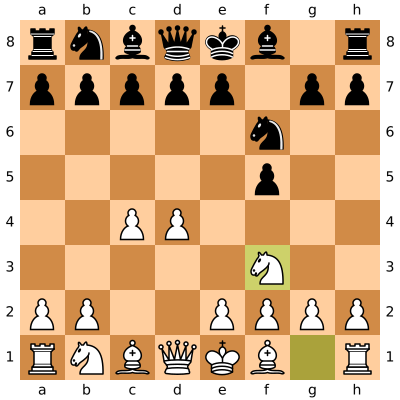

In [40]:
jogo_ate_i(array_jogadas)